# Natural disasters data

In order to have a global view on our "climate change" topic, we also needed information about the natural disasters. The kind of events recorded in the dataset we are using are listed here : https://www.nws.noaa.gov/directives/sym/pd01016005curr.pdf.
<br>
<br>
The dataset was created and maintained since 1950 by the national centers for environmental information in the USA. You can download the dataset from this link : https://www.ncdc.noaa.gov/stormevents/ftp.jsp.

# 1. Imports

In [1]:
# Imports for work in this notebook
import pandas as pd
from os import listdir
from os.path import join
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
from fastdtw import fastdtw

# Imports from results obtained by the team
from hach.cleaning import clean_df

# Options to make the whole notebook smoother
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.filterwarnings("ignore")

# 2. Loading Dataset
The dataset is split across mulitple files, from different years, of 3 types :
* Locations
* Fatalities
* Details

We have therefore combined all years of a type into one dataframe, so that we obtain 3 dataframes from the 3 different types.

### 2.1. Loading all files and performing the split

In [2]:
# Fetch all files in directory
files = [f for f in listdir('data/US - Storm Events/')]

# Load data from differnt files into array
dfs_loc = []
dfs_fat = []
dfs_det = []

for i in range(len(files)):
    filename = files[i]
    df = pd.read_csv(join('data/US - Storm Events/', filename), compression='gzip')
    
    if filename.startswith('StormEvents_locations'):
        dfs_loc.append(df)
    elif filename.startswith('StormEvents_fatalities'):
        dfs_fat.append(df)
    else:
        dfs_det.append(df)
    
df_loc = pd.concat(dfs_loc)
df_fat = pd.concat(dfs_fat)
df_det = pd.concat(dfs_det)

### 2.2. Analysing content of each dataset

In [3]:
df_loc.head()

,YEARMONTH,EPISODE_ID,EVENT_ID,LOCATION_INDEX,RANGE,AZIMUTH,LOCATION,LATITUDE,LONGITUDE,LAT2,LON2
0,201808,130479,780978,2,3.01,SSW,JACKSONVILLE,30.3100,-81.6900,3018600,8141400
1,201808,130479,780978,3,2.08,SSW,JACKSONVILLE,30.3238,-81.6871,3019428,8141226
2,201808,130479,780978,4,2.64,SSW,LAKE FOREST,30.3158,-81.6497,3018948,8138982
3,201808,130476,782301,4,1.52,NW,WEST AUBURN,41.7437,-76.1232,4144622,767392
4,201808,130476,782300,3,1.00,SSE,DIMOCK,41.7361,-75.8946,4144166,7553676


In [4]:
df_fat.head()

,FAT_YEARMONTH,FAT_DAY,FAT_TIME,FATALITY_ID,EVENT_ID,FATALITY_TYPE,FATALITY_DATE,FATALITY_AGE,FATALITY_SEX,FATALITY_LOCATION,EVENT_YEARMONTH
0,201804,13,0,35464,753636,I,04/13/2018 00:00:00,NaN,M,Outside/Open Areas,201804.0
1,201805,28,0,35476,754296,D,05/28/2018 00:00:00,7.0,M,Under Tree,201805.0
2,201805,9,0,39699,854804,I,05/09/2018 00:00:00,NaN,NaN,Unknown,201805.0
3,201807,23,0,39903,862273,D,07/23/2018 00:00:00,NaN,NaN,Unknown,201807.0
4,201807,26,0,39914,862273,D,07/26/2018 00:00:00,NaN,NaN,Unknown,201807.0


In [5]:
df_det.head() 

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,...,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
0,201905,9,1554,201905,9,1830,137295,824116,TEXAS,48,...,7.0,NNE,SAN GERONIMO,29.7898,-98.6406,29.7158,-98.7744,Thunderstorms developed along a cold front as ...,Thunderstorms produced heavy rain that led to ...,CSV
1,201907,15,1640,201907,15,1641,140217,843354,MINNESOTA,27,...,5.0,E,ROCK CREEK,45.7700,-92.8700,45.7700,-92.8700,An area of low pressure over southern Manitoba...,A 14-inch tree fell due to the winds and damag...,CSV
2,201909,4,1229,201909,4,1229,141212,848333,VERMONT,50,...,1.0,W,LUDLOW,43.4000,-72.7200,43.4000,-72.7200,A strong mid-level disturbance and cold front ...,Quarter size hail reported at Okemo Ski resort.,CSV
3,201909,26,1554,201909,26,1554,141215,848338,NEW YORK,36,...,5.0,SW,MADRID,44.6988,-75.2220,44.6988,-75.2220,A strong mid-level disturbance and cold front ...,A few trees and power lines downed by thunders...,CSV
4,201902,19,2226,201902,19,2350,134941,808922,ARKANSAS,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Rain was heavy at times on the 19th, and there...",One-quarter inch of freezing rain was measured...,CSV


# 3. Dataframe preparation
From our lookup of the 3 dataframes, we've come to the conclusion all the necessary and relevant information is contained in one dataset only and that is the "details" one. We chose to keep it because it has information on the **type of event**, **year**, **month**, **injuries due to weather events**, **deaths**, **amount of damage**.

### 3.1. Drop
We have looked into the published paper and chose the columns of interest.

In [6]:
cols_of_interest = ['YEAR', 'MONTH_NAME', 'STATE', 'EVENT_TYPE','EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT', 'DEATHS_INDIRECT', 'DAMAGE_PROPERTY','DAMAGE_CROPS','SOURCE']
df_det_skinned = df_det[cols_of_interest]

In [7]:
df_det_skinned.head()

,YEAR,MONTH_NAME,STATE,EVENT_TYPE,EPISODE_NARRATIVE,EVENT_NARRATIVE,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE
0,2019,May,TEXAS,Flash Flood,Thunderstorms developed along a cold front as ...,Thunderstorms produced heavy rain that led to ...,0,0,0,0,0.00K,0.00K,Law Enforcement
1,2019,July,MINNESOTA,Thunderstorm Wind,An area of low pressure over southern Manitoba...,A 14-inch tree fell due to the winds and damag...,0,0,0,0,0.00K,0.00K,Trained Spotter
2,2019,September,VERMONT,Hail,A strong mid-level disturbance and cold front ...,Quarter size hail reported at Okemo Ski resort.,0,0,0,0,0.00K,0.00K,Public
3,2019,September,NEW YORK,Thunderstorm Wind,A strong mid-level disturbance and cold front ...,A few trees and power lines downed by thunders...,0,0,0,0,5.00K,0.00K,Utility Company
4,2019,February,ARKANSAS,Ice Storm,"Rain was heavy at times on the 19th, and there...",One-quarter inch of freezing rain was measured...,0,0,0,0,0.00K,0.00K,911 Call Center


### 3.2. Date format and reordering
Given the months are written in plain text and that the notion of ordering for strings is not really clear, we convert the months into numbers (from 1 to 12), so that we can sort the dataset into years and then months.

In [8]:
# Convert months to numbers
df_det_skinned['MONTH_NAME'] = df_det_skinned.MONTH_NAME.apply(lambda x : datetime.datetime.strptime(x, "%B").month)

# Sort by year and month
df_det_skinned = df_det_skinned.sort_values(by=['YEAR', 'MONTH_NAME'], ascending=True)

df_det_skinned.head()

,YEAR,MONTH_NAME,STATE,EVENT_TYPE,EPISODE_NARRATIVE,EVENT_NARRATIVE,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE
65,2016,1,MISSISSIPPI,Hail,An upper level low pressure system moved throu...,Nickel to quarter size hail fell near Alligator.,0,0,0,0,0.00K,0.00K,Social Media
72,2016,1,MISSISSIPPI,Hail,Abundant moisture and instability combined wit...,NaN,0,0,0,0,0.00K,0.00K,Emergency Manager
73,2016,1,MISSISSIPPI,Thunderstorm Wind,Abundant moisture and instability combined wit...,A few trees were blown down in the Cranfield/L...,0,0,0,0,5.00K,0.00K,Emergency Manager
74,2016,1,MISSISSIPPI,Hail,Abundant moisture and instability combined wit...,NaN,0,0,0,0,0.00K,0.00K,Public
75,2016,1,MISSISSIPPI,Thunderstorm Wind,Abundant moisture and instability combined wit...,Trees and powerlines were blown down along Eas...,0,0,0,0,5.00K,0.00K,Amateur Radio


# 4. Information extraction

### 4.1. Number of event occurrences per year
We first look into the number extreme weather events every year.

Text(0, 0.5, 'Number of extreme weather events')

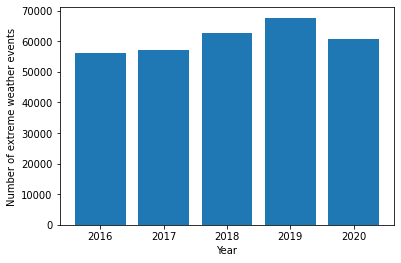

In [9]:
nb_events = []
years = range(2016, 2021) # This is the timeframe we are considering in other data analysis

for year in years:
    nb_events.append(len(df_det_skinned[df_det_skinned['YEAR'] == year]))

plt.bar(years, nb_events)
plt.xlabel('Year')
plt.ylabel('Number of extreme weather events')

We can see there is an upward trend potentially confirming an increase in the total number of events per year, but the hypothesis doesn't work for 2020.

### 4.2. Number of event occurrences per type of event and per year
Since point 4.1 did not give us much information, let's look at the events that happened every year in a bit more detail.

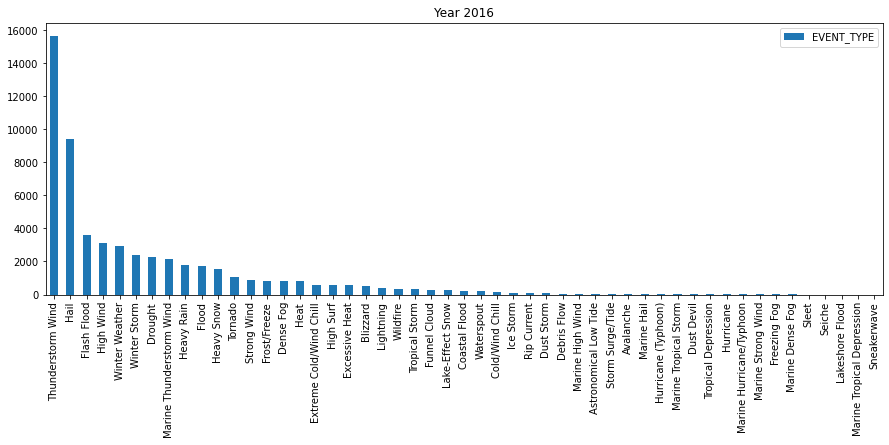

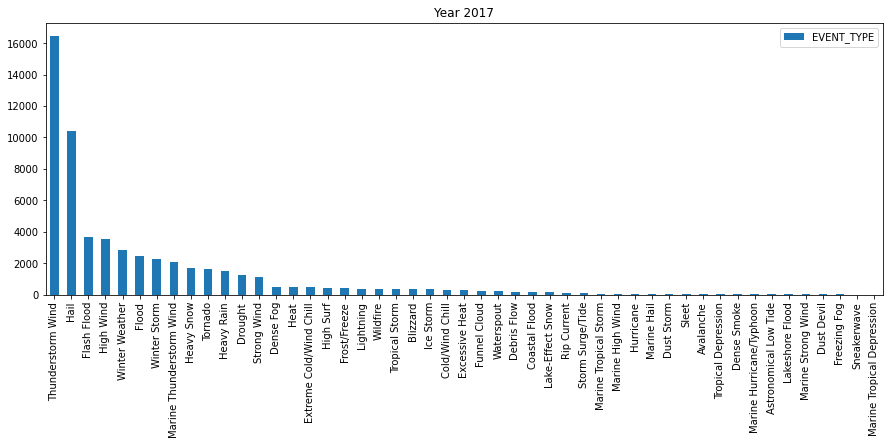

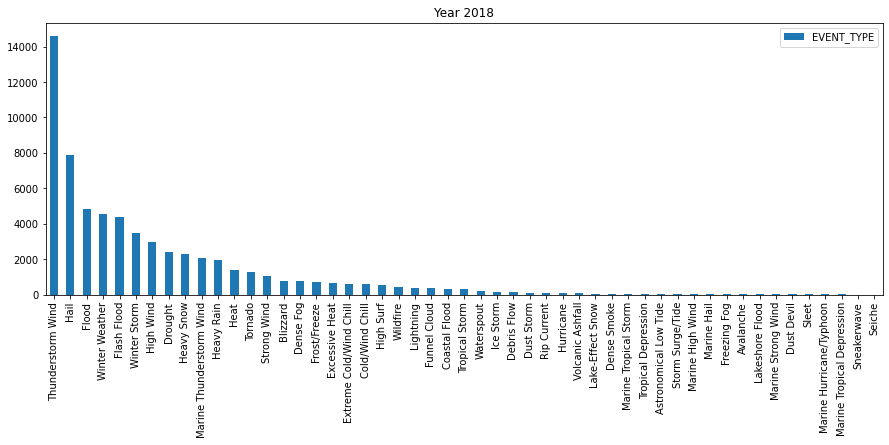

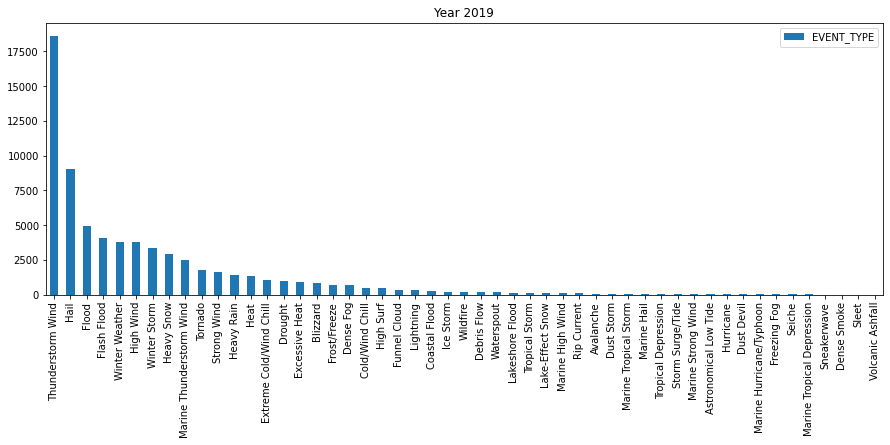

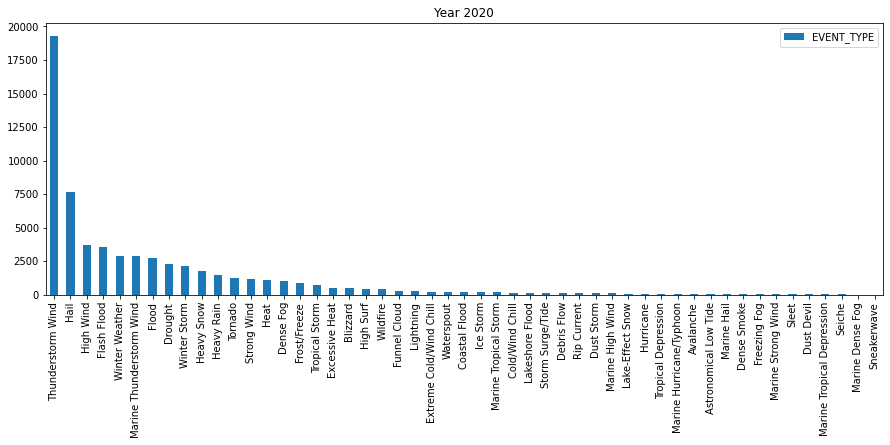

In [10]:
for year in years:
    df_year = df_det_skinned[df_det_skinned['YEAR'] == year]
    df_events = df_year[['EVENT_TYPE']]
    df_events_count = df_events.apply(pd.value_counts)
    df_events_count.plot(kind='bar', figsize=(15,5))
    plt.title('Year %i' %year)

We can see that not all extreme weather events are of interest for us, so we're going to look into the top 10 in more detail.

### 4.3. Top ten

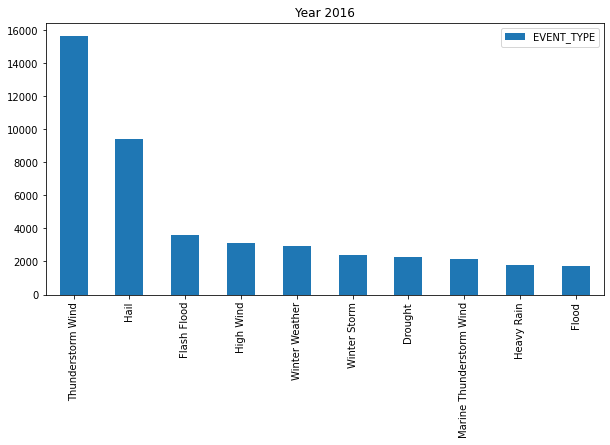

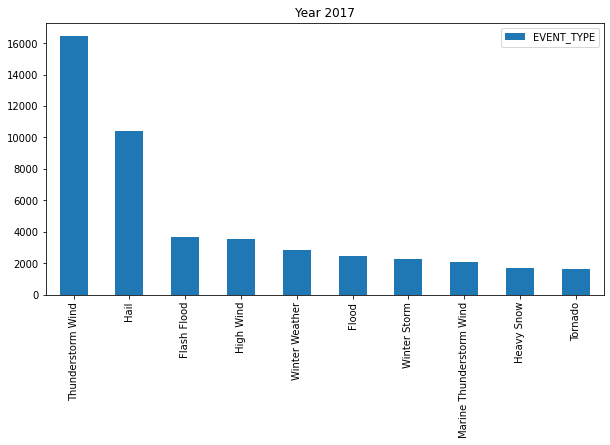

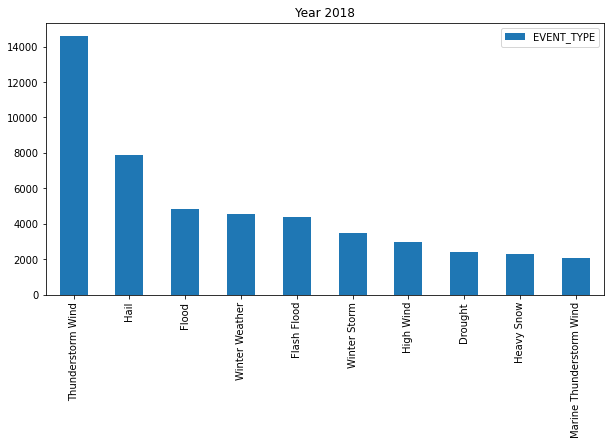

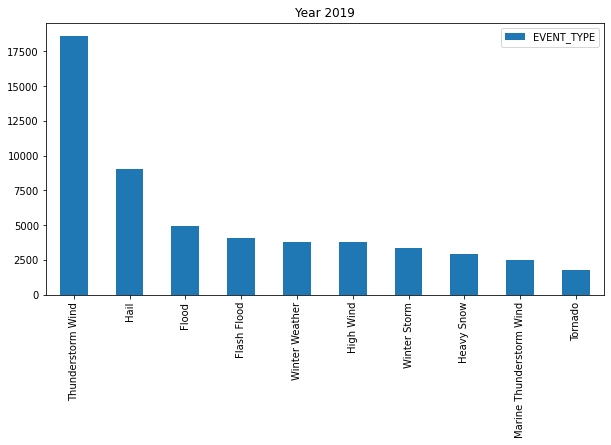

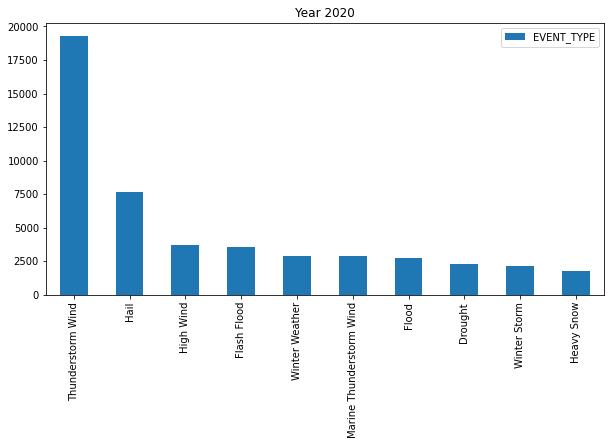

In [11]:
for year in years:
    df_year = df_det_skinned[df_det_skinned['YEAR'] == year]
    df_events = df_year[['EVENT_TYPE']]
    df_events_count = df_events.apply(pd.value_counts)
    df_events_count.sort_values(by='EVENT_TYPE') # Sort for later selection
    df_events_count[:10].plot(kind='bar', figsize=(10,5)) # Keep only the top 10
    plt.title('Year %i' %year)

### 4.4. Damage in property
Another measure we are given in the dataset is the estimated amount of damage to property incurred by the weather event. That is what we are focusing on now.

In [12]:
df_det_skinned = df_det_skinned.dropna(subset=["DAMAGE_PROPERTY"]) # We drop null values

In [13]:
# Quick check null values were dropped
df_det_skinned.DAMAGE_PROPERTY

65       0.00K
72       0.00K
73       5.00K
74       0.00K
75       5.00K
         ...  
60554    0.00K
60555    0.00K
60556    0.00K
60558    0.00K
60559    0.00K
Name: DAMAGE_PROPERTY, Length: 243478, dtype: object

##### 4.4.1. Replace damage numbers by actual floating point values

In [14]:
# Define function
def as_number(nb):
    if 'K' in nb:
        return float(nb.replace('K', '')) * 1000
    elif 'M' in nb:
        return float(nb.replace('M', '')) * 1000 * 1000
    elif 'B' in nb:
        return float(nb.replace('B', '')) * 1000 * 1000 * 1000

In [15]:
# Apply fuction
df_det_skinned['DAMAGE_PROPERTY'] = df_det_skinned.DAMAGE_PROPERTY.apply(as_number)

In [16]:
# Control it worked
df_det_skinned.DAMAGE_PROPERTY

65          0.0
72          0.0
73       5000.0
74          0.0
75       5000.0
          ...  
60554       0.0
60555       0.0
60556       0.0
60558       0.0
60559       0.0
Name: DAMAGE_PROPERTY, Length: 243478, dtype: float64

##### 4.4.2. Calculate sums of damage property per year and month and plot

In [17]:
# Calculate
df_damages = df_det_skinned.groupby(["YEAR","MONTH_NAME"]).DAMAGE_PROPERTY.sum()

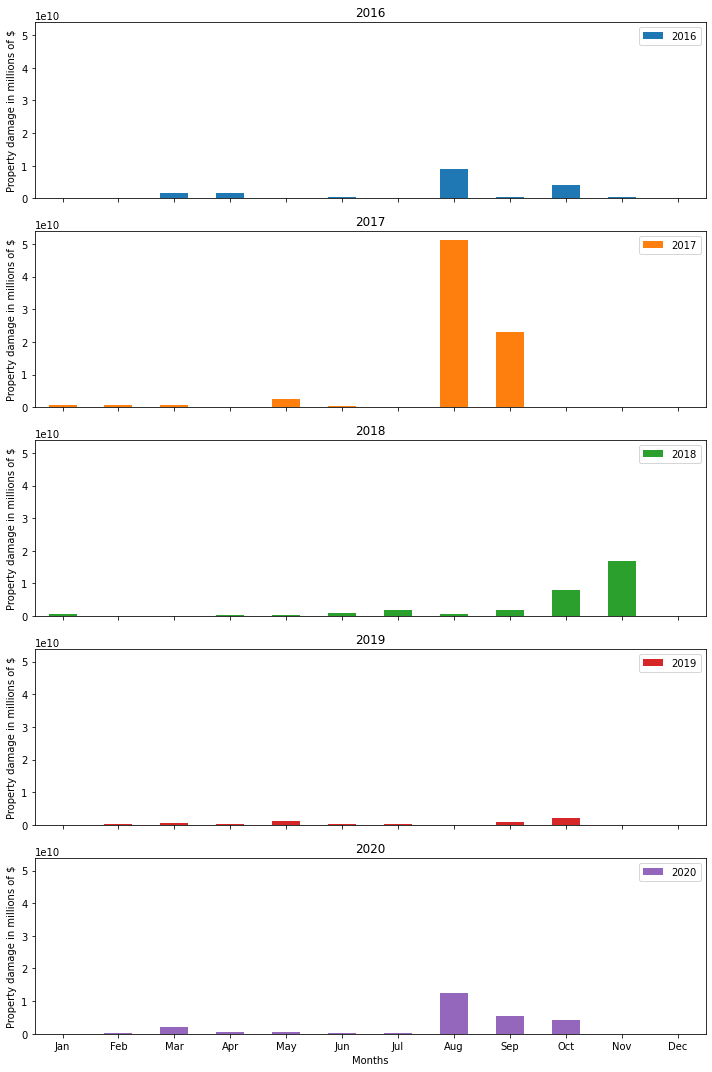

In [18]:
damage = df_damages.unstack(level=0).plot(kind='bar', 
                                         subplots=True, 
                                         rot=0, 
                                         figsize=(10, 15), 
                                         layout=(5, 1), 
                                         sharey=True, 
                                         ylabel="Property damage in millions of $", 
                                         xlabel="Months")

month_names = ['Jan','Feb','Mar','Apr','May','Jun',
               'Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(range(0, 12), month_names)
plt.tight_layout()

##### 4.4.3 Observations
It is obvious, some months had really high damage in property and it often corresponds to some big hurricanes happening in the US. Let us take the example of September 2017. After a quick google search, we could link it to hurricane Maria. But let's show it in our data.

In [19]:
select_year = df_det_skinned[df_det_skinned['YEAR'] == 2017]
select_month = select_year[select_year['MONTH_NAME'] == 9] # 9 is for September due to previous conversion
sorted_by_impact =  select_month.sort_values(by='DAMAGE_PROPERTY', ascending=False) # From biggest event to smallest
sorted_by_impact.head()

,YEAR,MONTH_NAME,STATE,EVENT_TYPE,EPISODE_NARRATIVE,EVENT_NARRATIVE,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE
370,2017,9,PUERTO RICO,Flash Flood,Hurricane Maria was a catastrophic category 4 ...,Rio de la Plata went out of its banks producin...,0,0,9,0,2.500000e+09,0.00K,Newspaper
452,2017,9,PUERTO RICO,Flash Flood,Hurricane Maria was a catastrophic category 4 ...,Very heavy rain resulted in Rio Canovanas out ...,0,0,0,0,7.500000e+08,0.00K,River/Stream Gage
451,2017,9,PUERTO RICO,Flash Flood,Hurricane Maria was a catastrophic category 4 ...,Heavy rain flooded municipality of Arroyo.,0,0,0,0,7.500000e+08,0.00K,Public
419,2017,9,PUERTO RICO,Flash Flood,Hurricane Maria was a catastrophic category 4 ...,"Rio Culebrinas was out of its banks, flooding ...",0,0,2,0,7.500000e+08,0.00K,River/Stream Gage
420,2017,9,PUERTO RICO,Flash Flood,Hurricane Maria was a catastrophic category 4 ...,Heavy rain resulted in floods.,0,0,0,0,7.500000e+08,0.00K,Unknown


We can see there were multiple reports for the same event.

# 5. Correlation with other data
We now want to look into how weather events correlate with data obtained from the quotebank dataset from other parts of our analysis.

### 5.3. Language complexity
At this point, we are looking into quotes talking about climate change adn their complexity. What we are trying to see here, is if any major extreme weather events could have had an influence into the complexity of the language used by papers to talk about climate change.

##### 5.3.1. Load data from years 2017 to 2020 into one dataframe

In [20]:
dfs = []
for year in range(2017, 2021):
    path = 'data/climate_df_complexity' + str(year) + '.pkl'
    df = pd.read_pickle(path)
    df = clean_df(df)
    dfs.append(df)
    
# Concatenate all years into one dataframe
df_complexity = pd.concat(dfs) 

##### 5.3.2. Prepare dataset for analysis

In [21]:
# Replace date column by year and month columns for later sorting
df_complexity['year'] = df_complexity.date.dt.year
df_complexity['month'] = df_complexity.date.dt.month

# Greta data starts in 2018 only, so we drop any values below that
#df_complexity = df_complexity[df_complexity.year > 2017]

# Order dataframe
df_mean_complexity_score = df_complexity.groupby(['year', 'month']).sentiment_score.sum()

In [22]:
df_mean_complexity_score.head()

year  month
2017  1         19.5247
      2        122.6503
      3        714.0692
      4        518.1625
      5        611.1239
Name: sentiment_score, dtype: float64

##### 5.3.2. Extract Greta data

In [23]:
# Select greta's quotes
df_greta = df_complexity[df_complexity.speaker == "Greta Thunberg"]

# Compute mean score per month
df_mean_sentiment_score_greta = df_greta.groupby(['year', 'month']).sentiment_score.sum()

In [24]:
df_mean_sentiment_score_greta.head()

year  month
2018  9        0.9986
      10       1.4005
      11       1.1806
      12      -7.1444
2019  1       -3.7668
Name: sentiment_score, dtype: float64

##### 5.3.2. Extract Trump data

In [25]:
# Select trump's quotes
df_trump = df_complexity[df_complexity.speaker == "Donald Trump"]

# Compute mean score per month
df_mean_sentiment_score_trump = df_trump.groupby(['year', 'month']).sentiment_score.sum()

In [26]:
df_mean_sentiment_score_trump.head()

year  month
2017  1        -0.0132
      2        -7.6550
      3        -5.1525
      4       -21.4207
      5       -23.3258
Name: sentiment_score, dtype: float64

##### 5.3.3. Plots
We look into the mean sentiment score every month, to see the global trend.

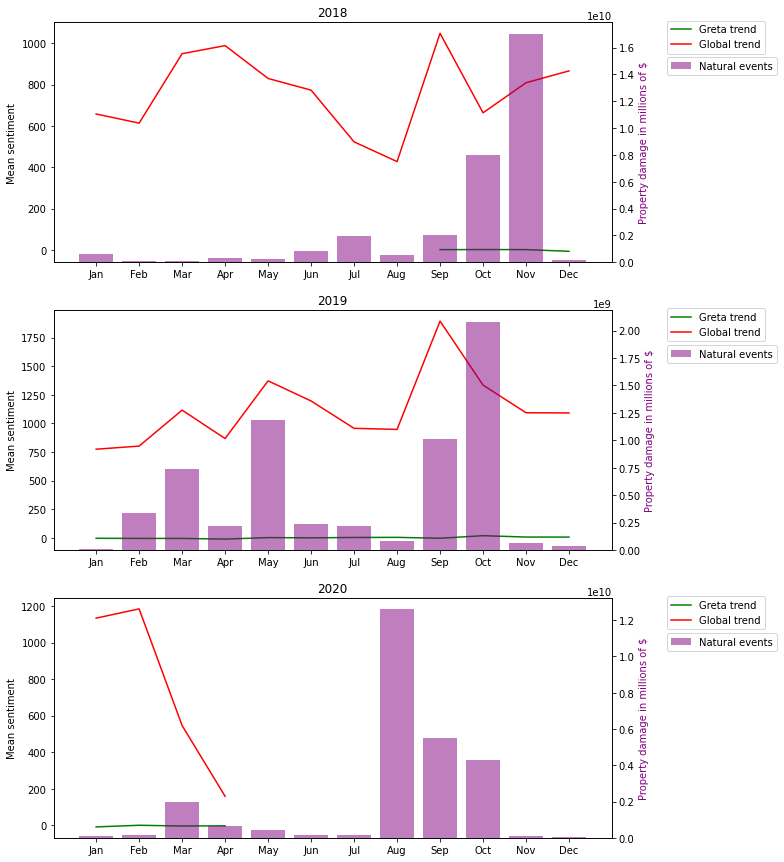

In [27]:
fig, ax = plt.subplots(3, figsize=(10,15))

# Greta scores
mean_sentiment_score_greta = df_mean_sentiment_score_greta.unstack(level=0)

# Global scores
mean_sentiment_score_global = df_mean_complexity_score.unstack(level=0)

# Weather events
natural = df_damages.unstack(level=0)

for i, year in enumerate(range(2018, 2021)):
    ax2 = ax[i].twinx()
    
    # Plotting language complexity lines
    #nat = ax2.plot(natural[year], color='purple', label='Natural events', alpha=0.5)
    nat = ax2.bar(x=range(1,13), height=natural[year], color='purple', label='Natural events', alpha=0.5)
    greta = ax[i].plot(mean_sentiment_score_greta[year], color='green', label='Greta trend')
    global_ = ax[i].plot(mean_sentiment_score_global[year], color='red', label='Global trend')
    
    # Parameters for plotting
    ax[i].set_ylabel('Mean sentiment')
    ax[i].set_title(str(year))
    ax[i].legend(loc=(1.1,0.87))
    
    ax2.set_ylabel('Property damage in millions of $', color='purple')
    ax2.legend(loc=(1.1,0.78))
    plt.xticks(range(1, 13), month_names)
    

sns.set_theme()
    

In [28]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [29]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [30]:
speakers = {}
for i in range(2017, 2021):
    speakers[i] = pd.read_pickle('data/speakers_{}.pkl'.format(i))
speakers = pd.concat(speakers)

In [31]:
speakers = speakers.reset_index(level=0, drop=True)

In [32]:
df_complexity = df_complexity.merge(speakers, on="speaker")

In [33]:
df_us = df_complexity[df_complexity.nationality == "United States of America"]

In [91]:
scores_sum = df_complexity.groupby(pd.Grouper(key="date", freq="M", label="left")).sum().reset_index()
scores_sum["date"] = scores_sum.date + pd.DateOffset(1)

,date,numOccurrences,sentiment_score,complexity,year,month,quotation_count,age
0,2016-12-31,873,39.3492,4829.0,911684,452,27388,23166.0
1,2017-01-31,10434,231.0908,44838.0,7832011,7766,141281,189142.0
2,2017-02-28,55349,1432.1362,147891.0,25436387,37833,566584,652966.0
3,2017-03-31,40526,935.3860,118663.0,20890069,41428,421427,523808.0
4,2017-04-30,78569,1440.0221,135786.0,23526288,58320,506022,612015.0
5,2017-05-31,104405,1977.4407,228506.0,40247218,119724,1201686,1111991.0
6,2017-06-30,45329,1696.4506,120958.0,21043361,73031,426738,542514.0
7,2017-07-31,52226,1304.3587,118064.0,20597604,81696,377006,531367.0
8,2017-08-31,51469,2286.5977,143350.0,25496897,113769,491290,651425.0
9,2017-09-30,65499,1891.2551,147450.0,25611866,126980,407966,630731.0


In [35]:
df_det_skinned['date'] = pd.to_datetime(df_det_skinned.YEAR*10000+df_det_skinned.MONTH_NAME*100+1,format='%Y%m%d') 

In [84]:
damages_sum = df_det_skinned.groupby(pd.Grouper(key="date", freq="m", label="left")).sum().reset_index()
damages_sum['date'] = damages_sum.date + pd.DateOffset(1)

In [85]:
# Function for easing of plotting numbers
def M_K(x):
    x = round(x/1000)
    
    if x >= 1000 * 1000:
        x = round(x/(1000*1000), ndigits=1)
        x = str(x) + 'B'
        return x
    elif x >= 1000:
        x = round(x/1000)
        x = str(x) + 'M'
        return x
    return str(x) + 'K'

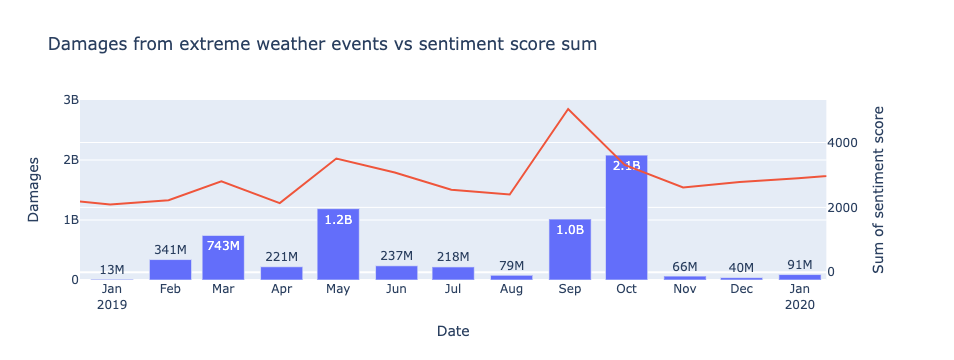

In [92]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
#fig = make_subplots()

# Add traces
fig.add_trace(
    go.Bar(x=damages_sum.date, y=damages_sum.DAMAGE_PROPERTY, text=damages_sum.DAMAGE_PROPERTY.apply(M_K)),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=scores_sum.date, y=scores_sum.sentiment_score),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Damages from extreme weather events vs sentiment score sum",
    showlegend=False
)

# Set x-axis title
fig.update_xaxes(
    title_text="Date",
    range=["2018-12-15","2020-01-15"],
    #ticklabelmode="period",
    tickformat="%b\n%Y",
    dtick="M1",
)

# Set y-axes titles
fig.update_yaxes(title_text="Damages", range=[0, 3e9], secondary_y=False)
fig.update_yaxes(title_text="Sum of sentiment score", secondary_y=True)

# remove labels

fig.show()
fig.write_html('plots/events_damages_sentiment.html', include_plotlyjs='cdn')

In [64]:
df_det_skinned[(df_det_skinned.YEAR == 2019) & (df_det_skinned.MONTH_NAME == 10)].sort_values(by="DAMAGE_PROPERTY", ascending=False).iloc[0].EPISODE_NARRATIVE

"Thunderstorms erupted across the DFW Metroplex as a strong upper level system and a cold front impacted the region on the evening of October 20 through the early morning hours of October 21st. A few storms developed ahead of the approaching cold front in the late evening hours of the 20th, producing tornadoes in Dallas and surrounding areas. Additional storms formed a squall line along the cold front, producing a large swath of damaging winds across North and Central Texas overnight into the early hours of October 21st. A total of 10 tornadoes were identified by NWS Survey teams, occurring both within the storms ahead of the cold front, and embedded within the squall line. The strongest of these tornadoes was an EF-3 that stretched almost 16 miles across the northern portions of Dallas County. Following on the heels of that tornado, an EF-2 tracked about 2.5 miles through Garland in Dallas County. The remaining count of tornadoes included 4 EF-1s and 4 EF-0s. Miraculously, no one was 

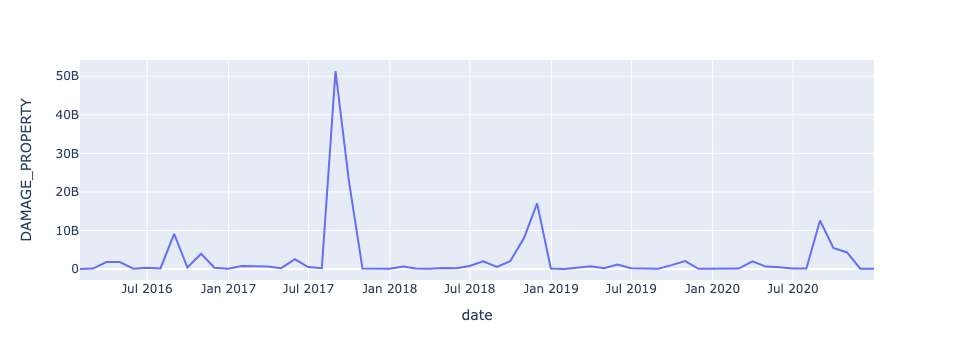

In [55]:
fig = px.line(damages_sum,x="date", y="DAMAGE_PROPERTY")
fig.show()

In [65]:
fig.write_html('plots/damages.html', include_plotlyjs='cdn')

##### 5.3.4. Measuring correlation
We would like to see if there is any signifant similirty between the differetn data using dynamic time warping.

In [30]:
# TODO